In [1]:
# Data
import numpy as np
import pandas as pd
import os
import csv
import xml.etree.ElementTree as ET

# Framework
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard

# Imaging
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


from tqdm import tqdm
from tensorflow.keras.utils import to_categorical

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.8)
sess = tf.Session(config = tf.ConfigProto(gpu_options=gpu_options))

In [15]:
from zipfile import ZipFile
file_name = 'data.zip'

if not os.path.isdir("blood-cells"):
    with ZipFile(file_name, 'r') as zip:
        zip.extractall()
        print("Done")

In [16]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5993873276704626713, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 5964053611830891100
 physical_device_desc: "device: XLA_CPU device"]

In [17]:

# Dicts for classifiers
dict_characters = {1:'NEUTROPHIL',2:'EOSINOPHIL',3:'MONOCYTE',4:'LYMPHOCYTE', 5:'BASOPHIL'}
dict_characters2 = {0:'Mononuclear',1:'Polynuclear'}

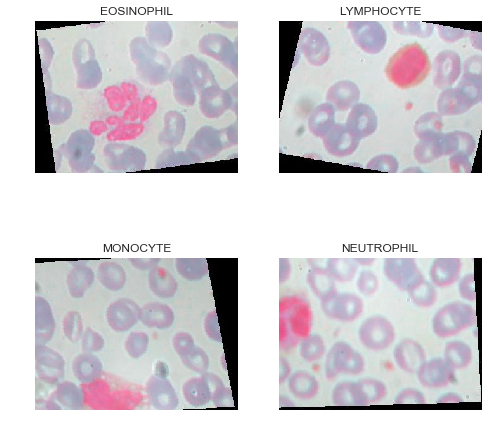

In [18]:
def plotImage(img_dir):
    img = cv2.imread(img_dir)
    plt.imshow(img)


# Demo different cell types
plt.figure(figsize=(8,8))

plt.subplot(221)
image_name = 'blood-cells/dataset2-master/images/TRAIN/EOSINOPHIL/_0_207.jpeg'
plt.title('EOSINOPHIL')
plt.axis('off')
plotImage(image_name)

plt.subplot(222)
image_name = 'blood-cells/dataset2-master/images/TRAIN/LYMPHOCYTE/_0_204.jpeg'
plt.title('LYMPHOCYTE')
plt.axis('off')
plotImage(image_name)

plt.subplot(223)
image_name = 'blood-cells/dataset2-master/images/TRAIN/MONOCYTE/_0_180.jpeg'
plt.title('MONOCYTE')
plt.axis('off')
plotImage(image_name)

plt.subplot(224)
image_name = 'blood-cells/dataset2-master/images/TRAIN/NEUTROPHIL/_0_292.jpeg'
plt.title('NEUTROPHIL')
plt.axis('off')
plotImage(image_name)

plt.show()

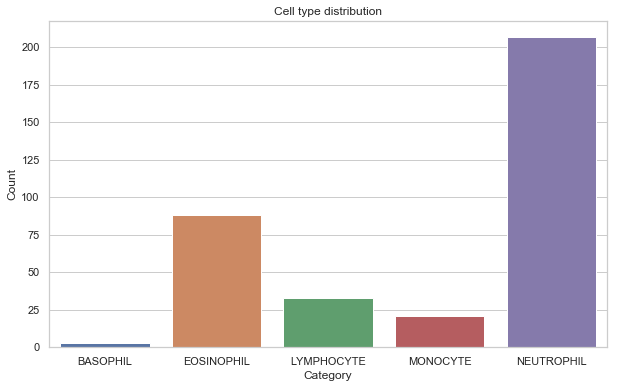

In [19]:
# Data distribution

df = pd.read_csv('blood-cells/dataset2-master/labels.csv')
df = df[['Image','Category']].dropna()
df1 = df[~df.Category.str.contains(",")]
x = df1.groupby('Category').count()

sns.set(style='whitegrid')
plt.figure(figsize=(10,6))
ax = sns.barplot(x = x.index, y = x['Image'])
ax.set(ylabel = 'Count', title = 'Cell type distribution')

plt.show()

In [42]:
# dict_characters = {1:'NEUTROPHIL',2:'EOSINOPHIL',3:'MONOCYTE',4:'LYMPHOCYTE', 5:'BASOPHIL'}
# dict_characters2 = {0:'Mononuclear',1:'Polynuclear'}

from tqdm import tqdm
from skimage.transform import resize
from tensorflow.keras.utils import to_categorical


def get_data(folder):
    """
    Load the data and labels from the given folder.
    """
    X = []
    y = []
    z = []
    for wbc_type in os.listdir(folder):
        if not wbc_type.startswith('.'):
            if wbc_type in ['NEUTROPHIL']:
                label = 1
                label2 = 1
            elif wbc_type in ['EOSINOPHIL']:
                label = 2
                label2 = 1
            elif wbc_type in ['MONOCYTE']:
                label = 3  
                label2 = 0
            elif wbc_type in ['LYMPHOCYTE']:
                label = 4 
                label2 = 0
            else:
                label = 5
                label2 = 0
                
                
            for image_filename in tqdm(os.listdir(folder + wbc_type)):
                img_file = cv2.imread(folder + wbc_type + '/' + image_filename)
                
                if img_file is not None:
                    img_file = resize(img_file, (60, 80, 3))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

# def get_data(src_folder):
#     imgs = []
#     labels = []
#     names = ['NEUTROPHIL', 'EOSINOPHIL', 'MONOCYTE', 'LYMPHOCYTE']
#     for name in names:
#         label = names.index(name)+1
#         for img_name in tqdm(os.listdir(src_folder + name)):
#             img_file = cv2.imread(image_name)
#             if img_file is not None:
#                 img_file = cv2.resize(img_file, (80, 80))
#                 img_arr = np.asarray(img_file)
#                 imgs.append(img_arr)
#                 labels.append(label)
#     return np.asarray(imgs), np.asarray(labels)

X_train, y_train = get_data('blood-cells/dataset2-master/images/TRAIN/')
X_test, y_test = get_data('blood-cells/dataset2-master/images/TEST/')


# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])

y_trainHot = to_categorical(y_train, num_classes = 5)
y_testHot = to_categorical(y_test, num_classes = 5)


# label1 is Basophil vs Eosinophil vs Lymphocyte vs Monocyte vs Neutrophil

print("\nWe don't really care about basophil anyway.\n")
print(dict_characters)

100%|██████████| 623/623 [00:01<00:00, 364.41it/s]



We don't really care about basophil anyway.

{1: 'NEUTROPHIL', 2: 'EOSINOPHIL', 3: 'MONOCYTE', 4: 'LYMPHOCYTE', 5: 'BASOPHIL'}


In [43]:
names = ['NEUTROPHIL', 'EOSINOPHIL', 'MONOCYTE', 'LYMPHOCYTE']
for name in names:
    label = names.index(name)+1
    print(name, label)
    
# Normalize the dataset

X_train=np.array(X_train)
X_train=X_train/255.

X_test=np.array(X_test)
X_test=X_test/255.

# plotHistogram(X_train[1])
# print(X_train[1].size/3/80)

NEUTROPHIL 1
EOSINOPHIL 2
MONOCYTE 3
LYMPHOCYTE 4


In [12]:
print("X_train:", X_train.size, "X_train_label", y_train.size)
print("X_train:", X_train.size, "X_train_label", y_trainHot.T.shape)


X_train: 191174400 X_train_label 9957
X_train: 191174400 X_train_label (4, 9957)


80.0


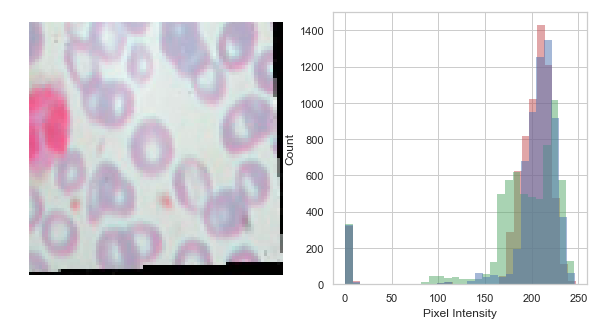

In [14]:
def plotHistogram(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);


plotHistogram(X_train[1])
print(X_train[1].size/3/80)

In [15]:
# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.333)
# sess = tf.Session(config = tf.ConfigProto(gpu_options=gpu_options))

# import time

# dense_layers = [1,2]
# layer_sizes = [32,64,128]
# conv_layers = [1,2,3]

# def build_CNN(x_train, x_label, y_test, y_label, batch_size = 128, epoch = 10):
#     num_category = len(x_label)
#     image_shape = x_train[0].shape
    
    
#     tensorborad = TensorBoard(log_dir='logs/{}'.format("testing"))

#     model = Sequential()

#     model.add(Conv2D(32, (3, 3), input_shape=image_shape))
#     model.add(Activation('relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.2))

    
#     model.add(Conv2D(64, (3, 3)))
#     model.add(Activation('relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.2))

    
#     model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

    
#     model.add(Dense(128))
#     model.add(Activation('relu'))

#     model.add(Dropout(0.5))
#     # model.add(Dense(64))
#     # model.add(Activation('relu'))

#     model.add(Dense(num_category))
#     model.add(Activation('softmax'))



#     model.compile(loss='categorical_crossentropy',
#                   optimizer='adam',
#                   metrics=['accuracy'])

# #                 model.fit(x_train, x_label, batch_size=32, epochs = epoch, validation_split=0.3, callbacks=[tensorborad])


#     datagen = ImageDataGenerator(
#                 featurewise_center=False,  # set input mean to 0 over the dataset
#                 samplewise_center=False,  # set each sample mean to 0
#                 featurewise_std_normalization=False,  # divide inputs by std of the dataset
#                 samplewise_std_normalization=False,  # divide each input by its std
#                 zca_whitening=False,  # apply ZCA whitening
#                 rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
#                 width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
#                 height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
#                 horizontal_flip=True,  # randomly flip images
#                 vertical_flip=False) 
#     print(model.summary)

#     model.fit_generator(x_train, x_label,
#                         epochs=epoch, 
#                         validation_data = [y_test, y_label],
#                         callbacks = [tensorborad])

# #     print(model.summary)
                
# ##########################################################################################
# # Command for calling tensorboard: 
# #tensorboard --logdir=logs/ --host localhost --port 8088
# ##########################################################################################

In [17]:
import time
num_category = len(y_trainHot[0])
image_shape = X_train[0].shape

NAME = "logs/{}-{}".format("testing", int(time.time()))

tensorboard = TensorBoard(log_dir=NAME)

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=image_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha = 0.05))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(LeakyReLU(alpha = 0.05))
model.add(Dropout(0.5))


model.add(Dense(num_category))
model.add(Activation('softmax'))


model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


datagen = ImageDataGenerator(
            rotation_range=10,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True) 

history = model.fit_generator(datagen.flow(X_train, y_trainHot, shuffle = True, batch_size=32),  epochs= 30)
model.save("model/"+ NAME +' .h5')


# ##########################################################################################
# # Command for calling tensorboard: 
# #tensorboard --logdir=logs/ --host localhost --port 8088
# ##########################################################################################

Epoch 1/30
 63/312 [=====>........................] - ETA: 1:09 - loss: 1.6573 - acc: 0.2386

KeyboardInterrupt: 

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 78, 78, 32)        896       
_________________________________________________________________
activation_12 (Activation)   (None, 78, 78, 32)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 39, 39, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 37, 37, 32)        9248      
_________________________________________________________________
activation_13 (Activation)   (None, 37, 37, 32)        0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 18, 18, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 64)        18496     
__________

In [ ]:
validation_loss, validation_accuracy = model.evaluate(X_test, y_testHot)
print("Validation loss", validation_loss)
print("Validation accuracy:",validation_accuracy)


In [2]:
from tensorflow.keras.models import load_model

# model.save('my_model.h5')
model = load_model('acc_may_31th.h5')
# model.evaluate(X_test, y_testHot)

In [11]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [44]:
validation_loss, validation_accuracy = model.evaluate(X_test, y_testHot)
print("Validation loss", validation_loss)
print("Validation accuracy:",validation_accuracy)


validation_loss, validation_accuracy = model.evaluate(X_train, y_trainHot)
print("Validation loss", validation_loss)
print("Validation accuracy:",validation_accuracy)


2487/2487 [==============================] - 3s 1ms/step
Validation loss 1.6473702251983062
Validation accuracy: 0.2505026135906715
9957/9957 [==============================] - 11s 1ms/step
Validation loss 1.6467622051316115
Validation accuracy: 0.25077834689163403
